# Titanic: Machine Learning from Disaster


In [1]:
# Importar módulos base - matplotlib for plotting, numpy and pandas

import numpy as np
import pandas as pd
%matplotlib inline

# Carregar arquivo de treino
train_dataset = pd.read_csv('./data/titanic/train.csv')
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Carregar arquivo de teste
test_dataset = pd.read_csv('./data/titanic/test.csv')
test_dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train_dataset.info()
print('_'*40)
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## Exploratory Data Analysis


Este é o primeiro passo para compreender a qualidade dos dados. Neste momento vamos combinar os dados de teste e de treino antes de iniciar nossa análise exploratória. 

### Let's take a look:

Above is a summary of our data contained in a Pandas DataFrame. Think of a DataFrame as a Python's super charged version of the workflow in an Excel table. As you can see the summary holds quite a bit of information. First, it lets us know we have 891 observations, or passengers, to analyze here:

> Int64Index: 891 entries, 0 to 890

Next it shows us all of the columns in DataFrame. Each column tells us something about each of our observations, like their name, sex or age. These colunms are called a features of our dataset. You can think of the meaning of the words column and feature as interchangeable for this notebook.
After each feature it lets us know how many values it contains. While most of our features have complete data on every observation, like the survived feature here:

> survived    891  non-null values 

some are missing information, like the age feature:

> age         714  non-null values 

These missing values are represented as NaNs.


A fim de combinar os 2 conjuntos de dados, precisamos criar uma coluna adicional no teste chamada 'sobreviveu' e adicionar o valor -1, a fim de sermos capazes de distinguir posteriormente os dados de treino e teste. Também há uma necessidade de reorganizar as colunas nos dados de treino para refletir o posicionamento das colunas dos dados de teste.

In [4]:
test_dataset.is_copy = False
test_dataset['Survived']=-1
train_dataset = train_dataset[['PassengerId','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked','Survived']]
mergedTitanicDS = train_dataset.append(test_dataset)

## Find Missing Data

In [5]:
for col in mergedTitanicDS:
    if mergedTitanicDS[col].isnull().sum()>0:
        print("Missing Values in %s %d" % (col,(mergedTitanicDS[col].isnull().sum())))

Missing Values in Age 263
Missing Values in Fare 1
Missing Values in Cabin 1014
Missing Values in Embarked 2


Como resultado, vemos acima os seguintes valores missing nos dados de treino.

### Embarked

Vamos começar atacando os mais simples. **Embarked** tem 2 valores em falta. É um ponto de dados categóricos e tem a seguinte distribuição:

In [6]:
# Get the distribution of the Embarked
mergedTitanicDS['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Temos pouca massa de manobra aqui. Uma estratégia consistente aqui poderia ser substituir os valores missing pelo valor de "S", já que o mesmo supera tanto "C" quanto "Q" em termos de númericos.

In [7]:
mergedTitanicDS.is_copy = False
mergedTitanicDS.loc[mergedTitanicDS['Embarked'].isnull(),'Embarked'] = 'S'

### Cabin

Vamos evoluir nossa análise. Olhando para o problemas dos dados missing na feature **cabin**, 

In [8]:
mergedTitanicDS['IsCabinDataEmpty'] = 0
mergedTitanicDS.loc[mergedTitanicDS['Cabin'].isnull(),'IsCabinDataEmpty'] = 1

### Age

A idade é um ponto de dados contínuo. Há 177 valores missing, o que representa cerca de 19% dos dados. Existem várias estratégias para substituição da idade, o mais simples é substituir por uma **média**, **mediana** ou **moda**. 

A armadilha nesta estratégia é que todos os passageiros com a idade em falta terão o mesmo valor estático, o que pode resultar em uma criança com a idade de um adulto.

> Importante! Esta é a fase mais pesada, a fase onde devemos conhecer os nossos dados a fim de definir a melhor estratégia possível.

### Title

Outro ponto importante aqui, é que temos junto aos nomes os títulos de tratamento para cada pessoa. Sendo assim podemos agregar a nossa estratégia de idade a indução da mesma com base no título.

Neste caso vamos extrair o título do nome e encontrar a média entre idadade e o título informado, e depois substituir os valores missing. Essa estratégia serve para ajudar a evitar substituir o valor missing de uma possível criança pela idade de um adulto. Assim diminuímos a margem de erro no tratamento de dados missing.

Extrair e cruzar os dados de idade com os dados de título é um exemplo de **Feature Engineering**, que visa tornar o conjunto de dados mais rico para o aprendizado.

In [9]:
# Extract the Title and assign it to the new column
mergedTitanicDS['Title'] = [nameStr[1].strip().split('.')[0] for nameStr in mergedTitanicDS['Name'].str.split(',')]

O gráfico abaixo exibe uma visão interessante da distribuição dos 17 títulos distintos em nosso dataset. Alguns dos títulos refletem Realeza, como por exemplo Jonkheer, título de nobreza holandesa.

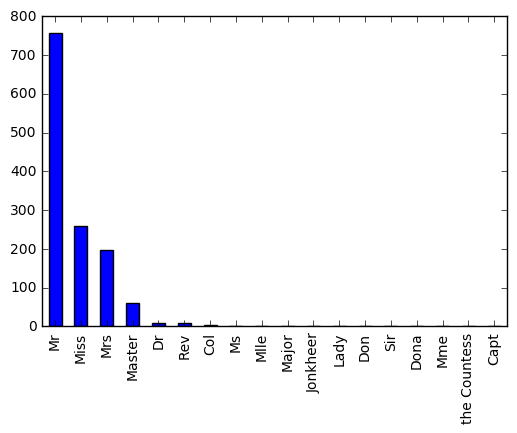

In [10]:
# The following plot shows the distribution of Titles
mergedTitanicDS['Title'].value_counts().plot.bar()

In [11]:
# Aggregate on Age by Title using mean
aggAgeByTitleDS = mergedTitanicDS[['Age','Title']].groupby(['Title']).mean().reset_index()

# Renaming the columns
aggAgeByTitleDS.columns = ['Title','Mean_Age']

# Merging by Title
mergedTitanicDS_Merged = pd.merge(mergedTitanicDS, aggAgeByTitleDS,on="Title")

# Replacing the missing values of Age by Mean Age
mergedTitanicDS_Merged.loc[mergedTitanicDS_Merged['Age'].isnull(),'Age']=mergedTitanicDS_Merged[mergedTitanicDS_Merged['Age'].isnull()]['Mean_Age']

### Fare

Há apenas um passageiro com dados missing sobre a tarifa. O passageiro em questão é senhor "Storey, Mr. Thomas". Se olharmos para os dados do senhor Thomas, veremos que ele viajou na classe Pclass 3. 

Neste caso podemos usar como estratégia, obter a média da tarifa paga pelos passageiros da classe Pclass 3.

In [12]:
# Applying the Fare for the missing values

mergedTitanicDS_Merged.loc[mergedTitanicDS_Merged['Fare'].isnull(),'Fare']=mergedTitanicDS_Merged[mergedTitanicDS_Merged['Pclass']==3]['Fare'].mean()

No contexto da aprendizagem de máquina, o foco não é sobre o certo ou errado, é sobre o grau de margem de erro. Vamos mais rumo ao "deeper into the rabbit hole"

Vamos nos aprofundar na Feature Engineering. As novas features, 'IsCabinDataEmpty' e 'Title', foram adicionados ao conjunto de dados, o que os torna mais ricos em informações, e dá uma pista melhor para solucionarmos nosso problema.

Temos embutido no nome um detalhe importante do passageiro, o 'Surname'. Essa é uma extração relativamente simples.

In [13]:
# Extracting Surname from the Name
mergedTitanicDS_Merged['Surname'] = [nameStr[0].strip() for nameStr in mergedTitanicDS_Merged['Name'].str.split(',')]


Outra característica interessante que pode ser abstraida do conjunto de dados seria o 'Family Size'. O "tamanho da família" poderia revelar alguma relação com os indices de sobrevivência.

Para ver se isso é uma possiblidade real vamos ver como obter estes dados. Olhando para nosso dataset, podemos usar os campo **SibSp**(siblings / spouses aboard) e **Parch**(parents / children aboard), para asbtrair esta informação.

Você poderia pensar em usar o Sobrenome como fonte para estipular esta relação, porém isso seria deveras arriscado, já que é relativamente simples haver passageiros que compartilhem o mesmo sobrenome sem nenhum tipo de parentesco.

In [14]:
# Creating a new column called Family Size
mergedTitanicDS_Merged['FamilySize']=mergedTitanicDS_Merged['SibSp']+mergedTitanicDS_Merged['Parch']+1

Há uma etapa adicional para tornar os dados compatíveis com o algoritmo de aprendizado da máquina. Vale lembrar que ao trabalhar com Machine Learning temos dois tipos de dados/variáveis: Categorical or Numerical. 

Vamos olhar para o dataset e entender o tipo de dados de cada atributo.

In [15]:
# Identify the data types
mergedTitanicDS_Merged.dtypes

PassengerId           int64
Pclass                int64
Name                 object
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
Survived              int64
IsCabinDataEmpty      int64
Title                object
Mean_Age            float64
Surname              object
FamilySize            int64
dtype: object

Obsserve os recursos do tipo object:
* Name
* Sex
* Ticket
* Cabin
* Embarked
* Title

Estes são os recursos precisamos aplicar alguma **transformação** a fim de torná-los compatíveis com o algoritmo de Machine Learning. Vamos começar com o **Sex** e **Name** que já foi dividido em **Title** e **Surname**.

Variáveis categóricas são conhecidas por ocultar e mascarar muitas informações interessantes em um conjunto de dados. É crucial aprender os métodos de lidar com essas variáveis. Em breve publico um caderno apenas sobre este assunto.

Em **Sex** temos 2 valores distintos **Male** e **Female**. Este campo é do tipo string. Precisamos representar este recurso de uma forma que possa ser usada para computação. Uma das opções é representar todos os passageiros do sexo masculino como 1 e todos os passageiros do sexo feminino como 0. Sendo assim, vamos criar um novo recurso chamado  **Sex_Cat** e atribuir os valores numéricos.

In [16]:
# Transforming the Sex Feature as Categorical
mergedTitanicDS_Merged['Sex_Cat'] = pd.Categorical.from_array(mergedTitanicDS_Merged.Sex).codes


Outra opção seria representá-los como um binário onde cada valor do recurso é representado como um recurso separado.

In [17]:
# Transform the Categorical Data Point to dummies
pd.get_dummies(mergedTitanicDS_Merged['Sex'])

,female,male
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Vamos optar pela segunda opção e vincular o resultado no dataframe original, onde tanto masculino como feminino são representados como características onde um ter o valor 1 e outro o valor 0.

In [18]:
# Converting Sex into a dummmy variable and binding it back to the original dataset
mergedTitanicDS_Merged = pd.concat([mergedTitanicDS_Merged,pd.get_dummies(mergedTitanicDS_Merged['Sex'])],axis = 1)

A mesma abordagem aplica-se aos dados Embarked, Title e Surname. 

In [19]:
# Converting Embarked into a dummmy variable and binding it back to the original dataset
mergedTitanicDS_Merged = pd.concat([mergedTitanicDS_Merged,pd.get_dummies(mergedTitanicDS_Merged['Embarked'])],axis = 1)

# Converting Title into a dummmy variable and binding it back to the original dataset
mergedTitanicDS_Merged = pd.concat([mergedTitanicDS_Merged,pd.get_dummies(mergedTitanicDS_Merged['Title'])],axis = 1)

Não vamos nos preocupar com o número de recursos que estamos anexando ao conjunto de dados.

Feature Selection é um tópico importante no campo da aprendizagem de máquina, e é sempre em conjunto com uma **target variable** ou **dependent variable**. Neste caso, a variável alve ou dependente é o **Survived**.


### Feature Selection

Seleção de recursos é um processo onde você seleciona automaticamente os recursos em seus dados que mais contribuem para a variável de previsão ou saída em que você está interessado. Ter muitos recursos irrelevantes em seus dados pode diminuir a precisão dos modelos. 

Aqui vamos usar a metodologia conhecida como **"Tree-based feature selection"**, usada para identificar os potenciais recursos. 

Três benefícios de realizar a seleção de recursos antes de modelar seus dados são:

* **Reduz a sobrealimentação**: Menos dados redundantes significa menos oportunidade de tomar decisões com base no ruído.
* **Melhora a precisão**: Menos dados enganosos significa que a precisão de modelagem melhora.
* **Reduz o Tempo de Treinamento**: Menos dados significa que os algoritmos treinam mais rapidamente.


In [20]:
# Lets drop the unwanted features 
mergedTitanicDS_Merged_Red = mergedTitanicDS_Merged.drop(mergedTitanicDS_Merged[
        ['Name','Sex','Ticket','Cabin','Embarked','Mean_Age','Surname','male','Title']], axis=1)


O código a seguir cria o feature dataset **(Xtrain)** e o dependente **(ytrain)** com os quais os recursos mais importantes são selecionados.

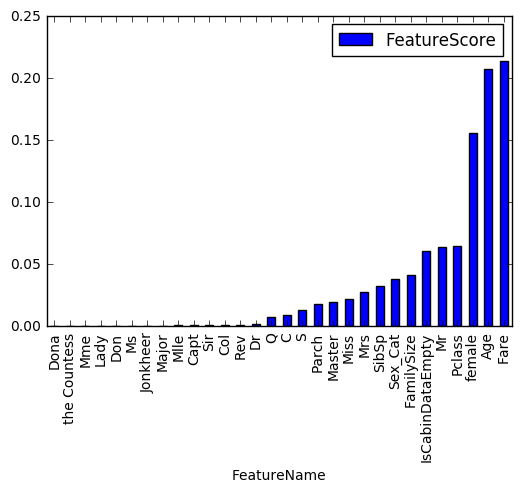

In [21]:
# Lets create the dataset that will be used for determining feature importance. 
featureNames = mergedTitanicDS_Merged_Red.ix[:,mergedTitanicDS_Merged_Red.columns.difference(['PassengerId','Survived'])].columns
Xtrain = mergedTitanicDS_Merged_Red[mergedTitanicDS_Merged_Red.Survived>=0].ix[:,mergedTitanicDS_Merged_Red.columns.difference(['PassengerId','Survived'])].values
ytrain = mergedTitanicDS_Merged_Red[mergedTitanicDS_Merged_Red.Survived>=0].ix[:,mergedTitanicDS_Merged_Red.columns == 'Survived'].values

Xtest = mergedTitanicDS_Merged_Red[mergedTitanicDS_Merged_Red.Survived<0].ix[:,mergedTitanicDS_Merged_Red.columns.difference(['PassengerId','Survived'])].values

# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris

from sklearn.feature_selection import *
clf = ExtraTreesClassifier()
clf = clf.fit(Xtrain, ytrain.ravel())

clf.feature_importances_
featureMatrixDS = pd.DataFrame({'FeatureName':featureNames.ravel(),'FeatureScore':clf.feature_importances_})
featureMatrixDS=featureMatrixDS.sort_values(by=['FeatureScore'])
featureMatrixDS.plot.bar('FeatureName','FeatureScore')

Agora vamos explorar mais técnicas da **seleção de recursos**. 

Vamos usar o **univariate  feature selection technique** (técnica de seleção de característica univariada), que usa um **square test qui** para testar a independência das características. **chi2** é tipicamente usado contra pontos de dados categóricos. Scikit tem uma função chamada SelectKBest, pela qual se pode obter a pontuação de cada recurso, quanto maior a pontuação mais valioso é o recurso.

O gráfico a seguir mostra o nome do recurso e sua pontuação. A importância das características pode ser observada da esquerda para a direita

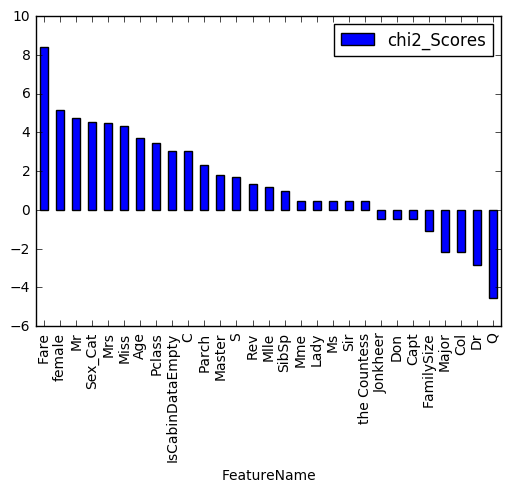

In [22]:
# Use the SelectKBest to run the chi square test
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import chi2

kBestSelector = SelectKBest(chi2, k='all')

Xtrain_Features = kBestSelector.fit(Xtrain,ytrain) 

featureMatrixDS_chi2 = pd.DataFrame({'FeatureName':featureNames,
                                     'chi2_pvalues':Xtrain_Features.pvalues_,
                                     'chi2_Scores':np.log(Xtrain_Features.scores_)})
featureMatrixDS_chi2_Sorted=featureMatrixDS_chi2.sort_values(by=['chi2_Scores'],ascending=False)
featureMatrixDS_chi2_Sorted[-featureMatrixDS_chi2_Sorted['chi2_Scores'].isnull()].plot.bar('FeatureName','chi2_Scores')

A seguir estão alguns dos recursos que são considerados importantes por ambas as abordagens: Fare, Age, female, Mr, Pclass, Mrs, IsCabinDataEmpty, SibSp, Parch, Miss

Existem outras características em que ambas as abordagens discordam. Neste caso seria uma boa idéia remover estes recursos, por exemplo: FamilySize tem uma classificação alta no Tree Approach e baixa no chi2.

Random Forest é uma técnica avançada que cria várias árvores e chega ao resultado final com base na maioria, também expõe a importância da característica.

Cria uma random forest no contexto do titanic usando o randomforestclassifier.

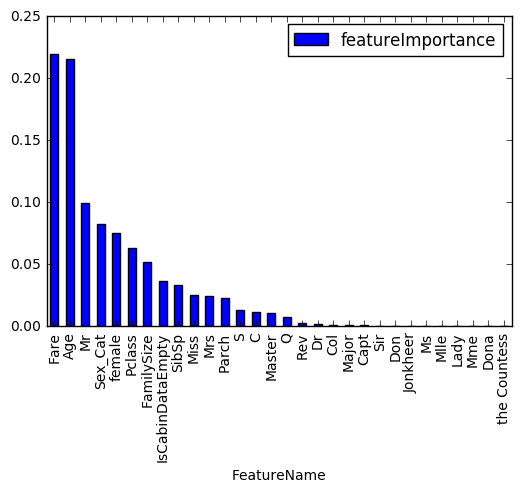

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,max_features ="auto")

rf.fit(Xtrain, ytrain.ravel())
featureMatrixDS_randforest = pd.DataFrame({'FeatureName':featureNames.ravel(),'featureImportance':
                                           list(map(lambda x: round(x, 4), rf.feature_importances_))})

featureMatrixDS_randforest=featureMatrixDS_randforest.sort_values(by=['featureImportance'],ascending=False)
featureMatrixDS_randforest.plot.bar('FeatureName','featureImportance')

O método seguinte é outra técnica para descrever a importância de uma determinada feature permutando o seu valor e encontrando o efeito correspondente nas métricas do modelo. Isso é chamado de "Mean decrease accuracy" (Precisão de diminuição média).

Neste método, o modelo é treinado em todos os recursos e cada uma das suas características é permutada uma a uma. Em cada iteração de permute o desempenho do modelo é medido e é comparado com o modelo original. As características que são de nenhuma importância provavelmente não terão nenhum efeito por causa do permute. Esta métrica não é fornecida por padrão no scikit e, portanto, programada para calculá-lo

In [37]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import *
from collections import defaultdict
  
scores = defaultdict(list)

blabla = ShuffleSplit(len(Xtrain), 20, .3)


# for ShuffleSplit takes the entire dataset of 891 data point runs the iteration 20 times and in each iteration it gives 30% of the data point as a test
for train_idx, test_idx in blabla.split(Xtrain):
    X_train, X_test = Xtrain[train_idx], Xtrain[test_idx]
    Y_train, Y_test = ytrain[train_idx], ytrain[test_idx]
# The model is trained on the training dataset and the model performance is calculated using the f1_score
    r = rf.fit(X_train, Y_train.ravel())
    acc = f1_score(Y_test, rf.predict(X_test))
# The below loop is repeated across each of the features in X and in each iteration the each of the feature values are randomly 
# shuffled and the predict against the shuffled dataset. The model performance is measured against each features change.
    for i in range(Xtrain.shape[1]):      
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = f1_score(Y_test, rf.predict(X_t))
        scores[featureNames[i]].append((acc-shuff_acc)/acc)
# At the end of the process, an array of features and its corresponding effect on the model is recorded.
# A mean of the effect across the features relays the importance of the feature
print("Features sorted by their score:")
print(sorted([(round(nvp.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

featureMatrixDS_rf_mda = pd.DataFrame(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))
featureMatrixDS_rf_mda.columns = ['FeatureEffect','FeatureName']
featureMatrixDS_rf_mda.plot.bar('FeatureName','FeatureEffect')

KeyboardInterrupt: 

In [38]:
featureMatrixDS_rf_mda[featureMatrixDS_rf_mda['FeatureEffect']!=0].plot.bar('FeatureName','FeatureEffect')

NameError: name 'featureMatrixDS_rf_mda' is not defined